In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from tqdm import tqdm
import os
import joblib


In [311]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[Link To Data](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

In [314]:
# load in data
df = pd.read_csv("/Users/praswishbasnet/Desktop/Heart-Disease-Prediction/data/heart_disease_data.csv")


# Exploratory Data Analysis (EDA)

### EDA Plan: What questions do we want to ask of the data?
1. Tabular descriptors to get a basic sense of the types of features in the dataset
2. How many positive and negative examples are there of the target variable?
3. How are continuous variables distributed (in particular, are they normally distributed)?
4. How do continuous variables change in conjunction with the target variable?
5. How many examples are there of each categorical variable?
6. How does each categorical variable change in conjunction with the target variable?

## EDA Step 1: Tabular Descriptors

In [316]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

### Attribute information:
1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

In [318]:
# Summary statistics for numerical features
numerical_features = df.select_dtypes(include=[np.number])
numerical_features = numerical_features.drop(["HeartDisease", "FastingBS"], axis=1)
numerical_features.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


In [320]:
# Summary statistics for categorical features
categorical_features = df.select_dtypes(include=[object])
categorical_features.describe()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [168]:
# Check for null values in the dataset
df.isnull().sum()  # there are none, great [although later I find that cholesterol has null values set to 0]

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## EDA step 2: visualizing the dataset

### How many positive and negative examples are there of the target variable?

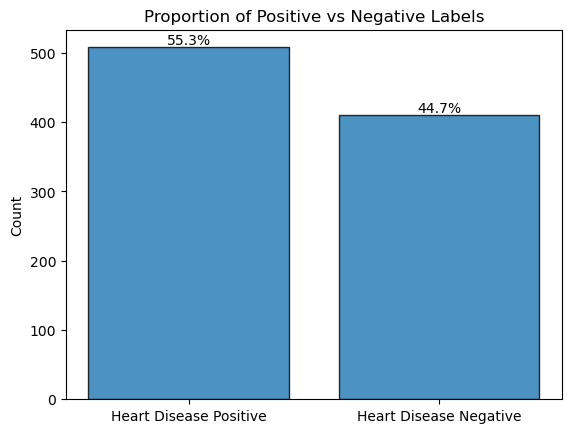

In [171]:
fig, ax = plt.subplots(1, 1)
bar_data = df["HeartDisease"].value_counts()
ax.bar([0, 1], bar_data, edgecolor="black", alpha=0.8)

ax.set_xticks([0, 1])
ax.set_xticklabels(["Heart Disease Positive", "Heart Disease Negative"])

for i, count in enumerate(bar_data):
    percentage = count / bar_data.sum() * 100
    ax.text(i, count, f"{percentage:.1f}%", ha="center", va="bottom")
ax.set_ylabel("Count")
ax.set_title("Proportion of Positive vs Negative Labels")
plt.show()

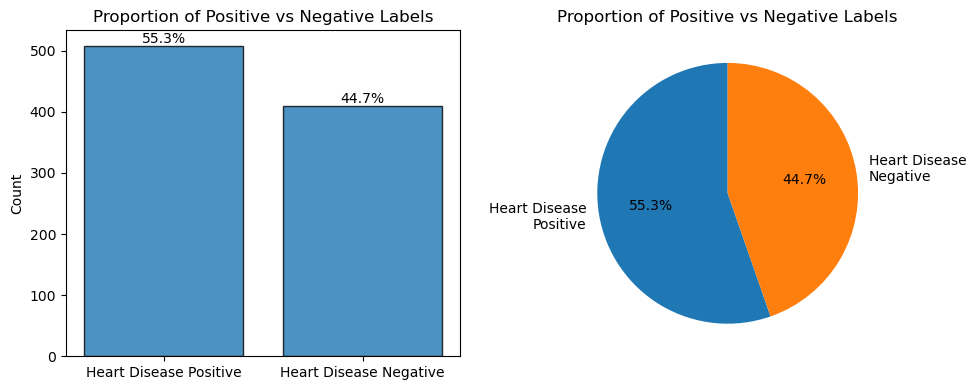

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Bar chart
ax_bar = axes[0]
bar_data = df["HeartDisease"].value_counts()
ax_bar.bar([0, 1], bar_data, edgecolor="black", alpha=0.8)
ax_bar.set_xticks([0, 1])
ax_bar.set_xticklabels(["Heart Disease Positive", "Heart Disease Negative"])
for i, count in enumerate(bar_data):
    percentage = count / bar_data.sum() * 100
    ax_bar.text(i, count, f"{percentage:.1f}%", ha="center", va="bottom")
ax_bar.set_ylabel("Count")
ax_bar.set_title("Proportion of Positive vs Negative Labels")

# Pie chart
ax_pie = axes[1]
labels = ["Heart Disease\nPositive", "Heart Disease\nNegative"]
sizes = bar_data.values
ax_pie.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax_pie.set_title("Proportion of Positive vs Negative Labels")

plt.tight_layout()
plt.savefig(os.path.join("visualizations", "label_quantity.png"), dpi=300)
plt.show()

The dataset is pretty balanced, I shouldn't need to worry about any sort of rebalancing or Synthetic Minority Over-sampling

### How are continuous variables distributed (in particular, are they normally distributed)?

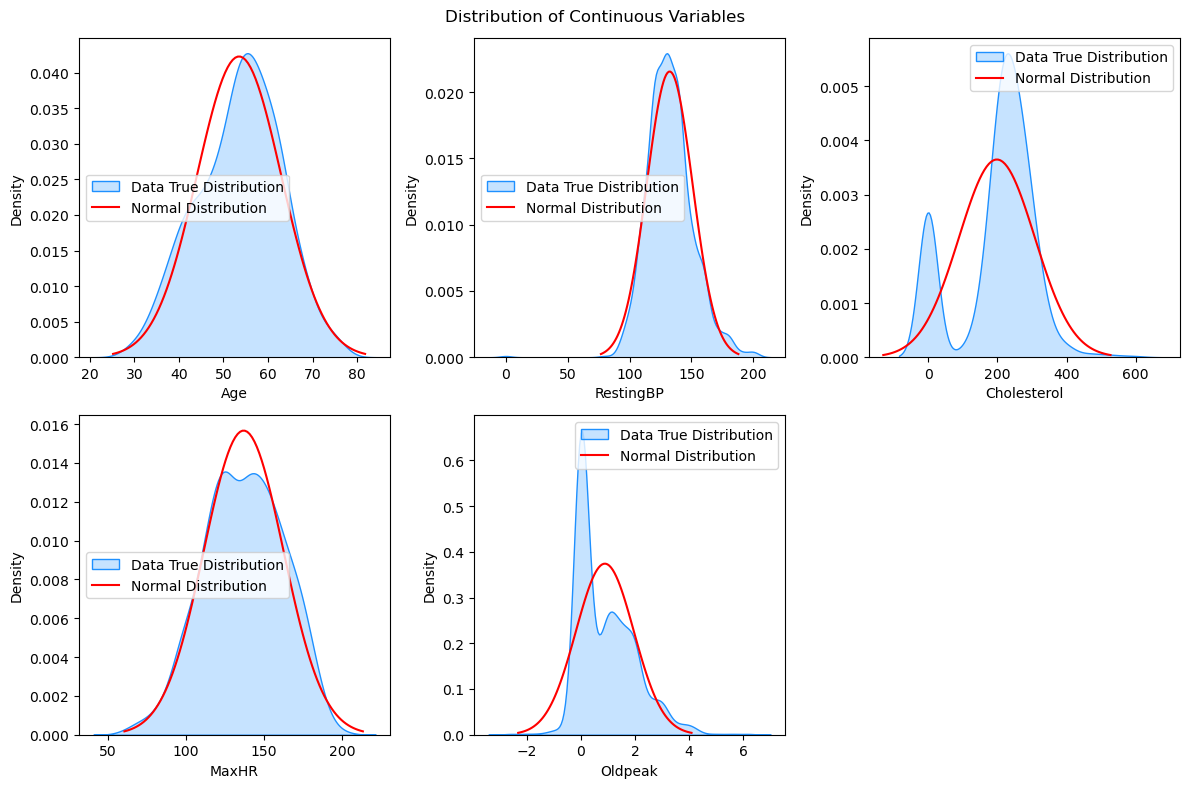

In [175]:
continuous_feature_names = numerical_features.columns.tolist()

num_features = len(continuous_feature_names)
num_rows = 2  # Number of rows in the subplot grid
num_cols = 3  # Number of columns in the subplot grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

for i, cont_feature in enumerate(numerical_features):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax_kde = axes[row, col]

    # Plot KDE for the feature
    sns.kdeplot(df[cont_feature], ax=ax_kde, fill=True, color="dodgerblue", label="Data True Distribution")

    # Add normal distribution curve
    mean = df[cont_feature].mean()
    sd = df[cont_feature].std()
    x = np.linspace(mean - 3 * sd, mean + 3 * sd, 100)
    y = stats.norm.pdf(x, mean, sd)
    ax_kde.plot(x, y, color="red", label="Normal Distribution")
    ax_kde.legend()  # Add legend to the current subplot


# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.suptitle("Distribution of Continuous Variables")
plt.tight_layout()
plt.savefig(os.path.join("visualizations", "continuous_distribution.png"), dpi=300)
plt.show()

In [176]:
df["Cholesterol"].value_counts()

Cholesterol
0      172
254     11
223     10
220     10
230      9
      ... 
392      1
316      1
153      1
466      1
131      1
Name: count, Length: 222, dtype: int64

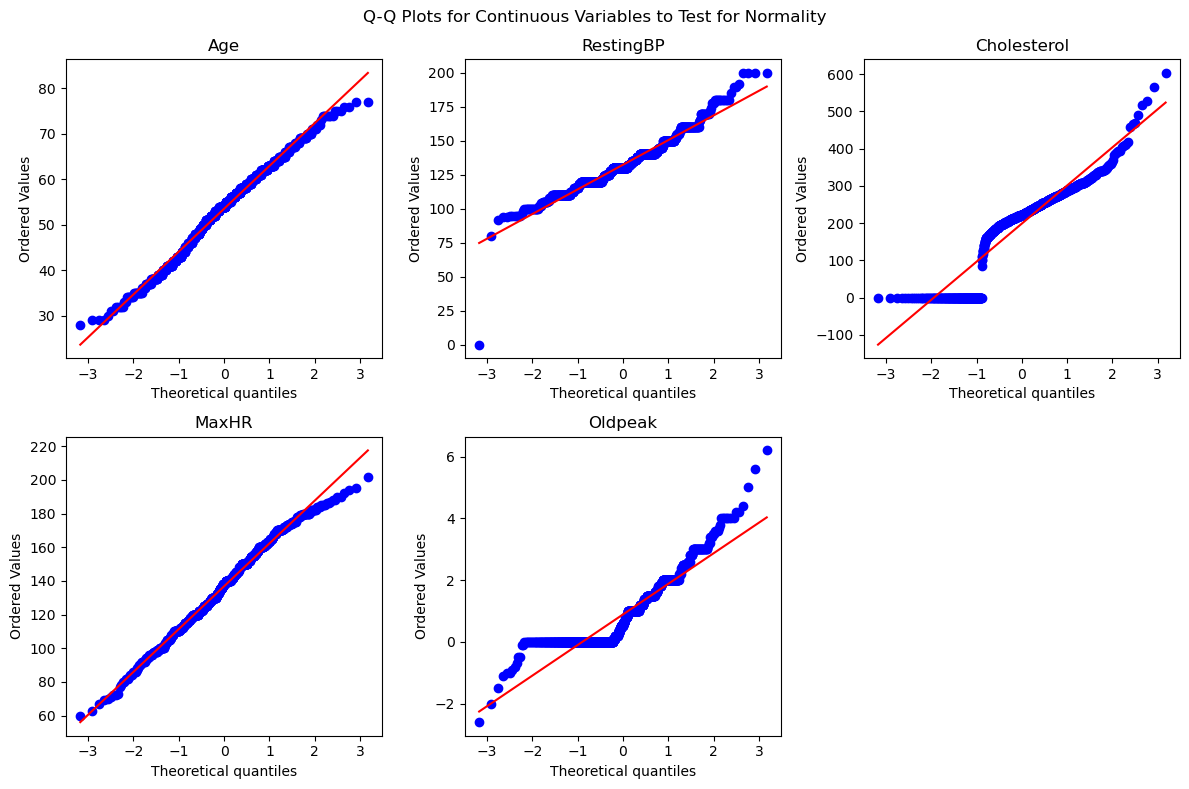

In [177]:
num_features = len(continuous_feature_names)
num_rows = 2  # Number of rows in the subplot grid
num_cols = 3  # Number of columns in the subplot grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

for i, cont_feature in enumerate(continuous_feature_names):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax_qq = axes[row, col]

    # Generate QQ-plot
    stats.probplot(df[cont_feature], plot=ax_qq)
    ax_qq.set_title(cont_feature)  # Set the title as the feature name

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.suptitle("Q-Q Plots for Continuous Variables to Test for Normality")
plt.tight_layout()
plt.savefig(os.path.join("visualizations", "qq_plots.png"), dpi=300)
plt.show()

/var/folders/03/g1kt45_d2t9_n8s_b6srk9_w0000gn/T/ipykernel_10833/220496824.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shapiro_wilk_results = pd.concat([shapiro_wilk_results, temp_df], ignore_index=True)


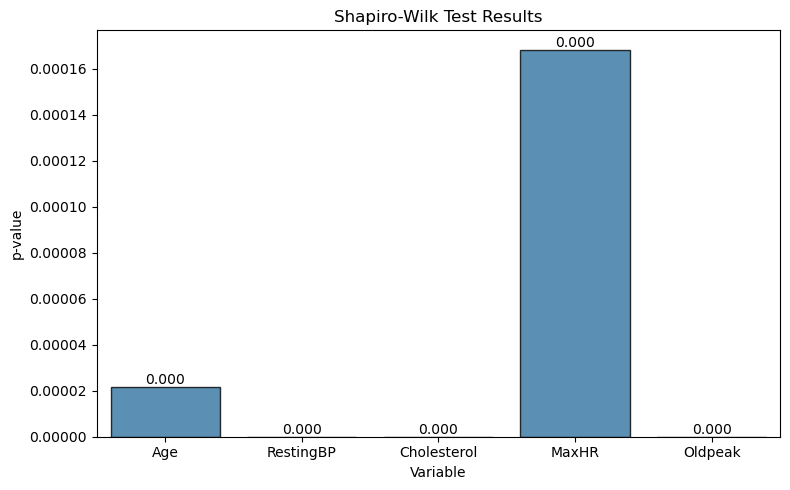

,Variable,Test Statistic,p-value
0,Age,0.991012,2.165168e-05
1,RestingBP,0.958043,1.494811e-15
2,Cholesterol,0.870595,6.976265e-27
3,MaxHR,0.992672,1.683352e-04
4,Oldpeak,0.859879,8.271839e-28


In [322]:
# Create an empty DataFrame to store the results
shapiro_wilk_results = pd.DataFrame(columns=["Variable", "Test Statistic", "p-value"])

# Iterate over the features and perform the Shapiro-Wilk test
for feature in continuous_feature_names:
    # Extract the data for the current feature
    data = df[feature]
    # Perform Shapiro-Wilk test
    statistic, p_value = stats.shapiro(data)
    # Create a temporary DataFrame for the current result
    temp_df = pd.DataFrame({"Variable": [feature], "Test Statistic": [statistic], "p-value": [p_value]})

    # Concatenate the temporary DataFrame with the results DataFrame
    shapiro_wilk_results = pd.concat([shapiro_wilk_results, temp_df], ignore_index=True)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 5))
# Create the bar plot using seaborn
barplot = sns.barplot(data=shapiro_wilk_results, x="Variable", y="p-value", edgecolor="black", alpha=0.8)

# Set labels and title
ax.set_xlabel("Variable")
ax.set_ylabel("p-value")
ax.set_title("Shapiro-Wilk Test Results")

# Add the p-value labels above each bar
for p in barplot.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height, f"{height:.3f}", ha="center", va="bottom")

# Display the plot
plt.tight_layout()
plt.show()

# Display the results in a dataframe
display(shapiro_wilk_results)

In [324]:
print(len(df[df["Cholesterol"]==0])) # number of cholesterol null values

172


Takeaways:
1. It looks like cholesterol was set to 0 as a null value, because people can't actually have 0 cholesterol and there are 172 entries of 0 cholesterol
2. Age, RestingBP, MaxHR look pretty close to normally distributed
3. Cholesterol's non-zero distribution looks pretty close to Gaussian
3. Oldpeak doesn't look Gaussian
4. Despite how the distributions appear, none of them are normally distributed, as determined by shapiro-wilk test and Q-Q plot looking imperfect

## How do continuous variables change in conjunction with the target variable?

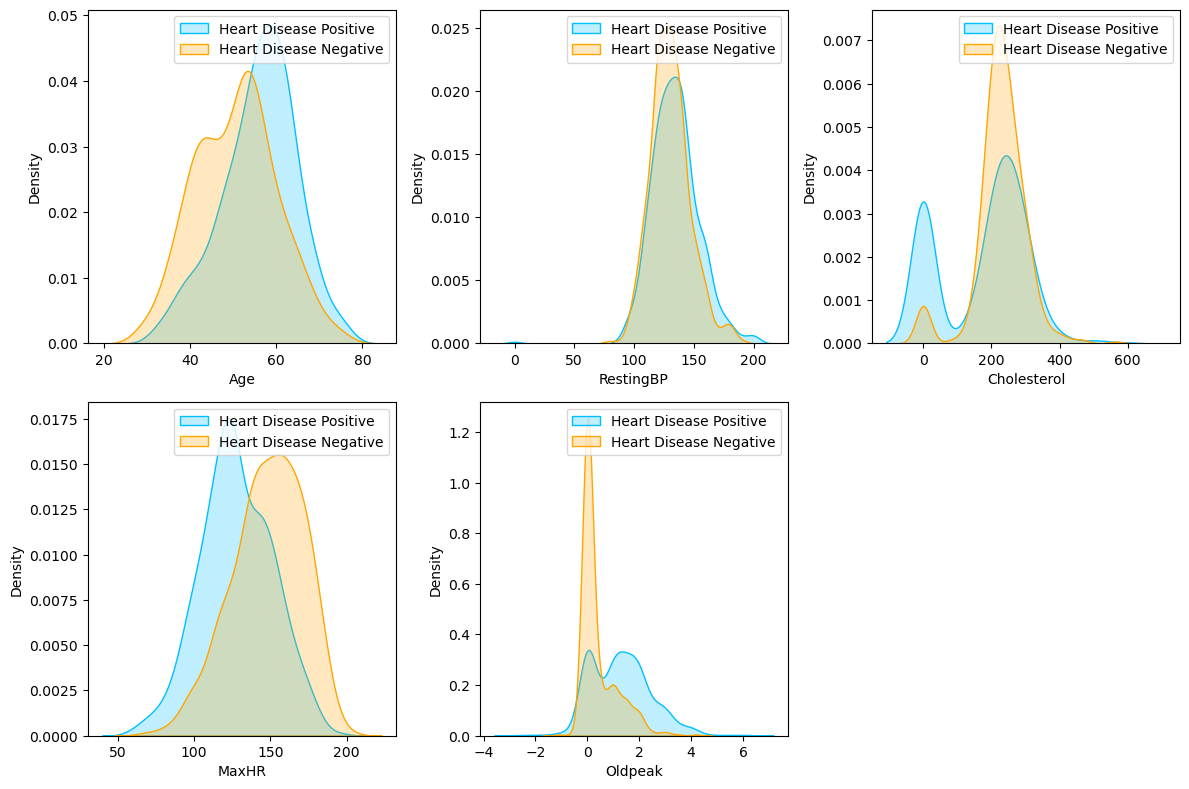

In [182]:
positive = df[df["HeartDisease"] == 1]  # Subset of data for heart failure cases
negative = df[df["HeartDisease"] == 0]  # Subset of data for non-heart failure cases

num_features = len(continuous_feature_names)
num_rows = 2  # Number of rows in the subplot grid
num_cols = 3  # Number of columns in the subplot grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

for i, cont_feature in enumerate(numerical_features):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax_kde = axes[row, col]

    # Plot KDE for heart failure positive cases
    sns.kdeplot(positive[cont_feature], ax=ax_kde, fill=True, color="deepskyblue", label="Heart Disease Positive")

    # Plot KDE for heart failure negative cases
    sns.kdeplot(negative[cont_feature], ax=ax_kde, fill=True, color="orange", label="Heart Disease Negative")

    ax_kde.legend()

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.savefig(os.path.join("visualizations", "continuous_target.png"), dpi=300)
plt.show()

In [183]:
display(df[(df["Cholesterol"]!=0) & (df["HeartDisease"]==0)]["Cholesterol"].describe())

count    390.000000
mean     238.769231
std       55.394617
min       85.000000
25%      203.000000
50%      231.500000
75%      269.000000
max      564.000000
Name: Cholesterol, dtype: float64

compare mean of each feature for positive vs negative

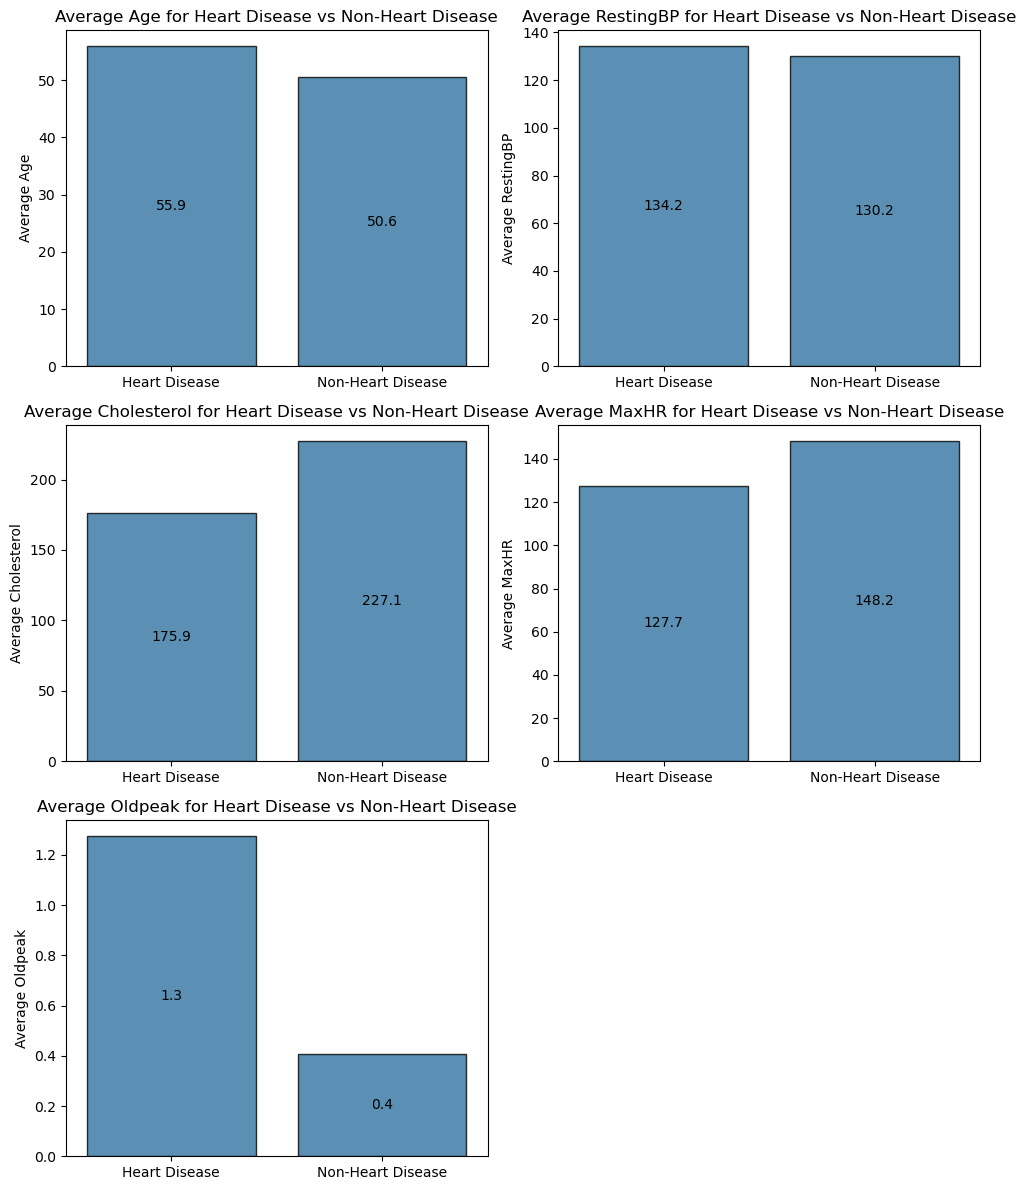

In [185]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Looping through each feature
for i, feature in enumerate(continuous_feature_names):
    row = i // 2  # Calculate the row index for the subplot
    col = i % 2  # Calculate the column index for the subplot

    avg_heart_failure = positive[feature].mean()
    avg_non_heart_failure = negative[feature].mean()

    # Creating the bar chart for the current feature
    ax = axes[row, col]
    # ax.bar(["Heart Disease", "Non-Heart Disease"], [avg_heart_failure, avg_non_heart_failure])
    sns.barplot(x=["Heart Disease", "Non-Heart Disease"], y=[avg_heart_failure, avg_non_heart_failure], ax=ax, edgecolor="black", alpha=0.8)
    ax.set_ylabel("Average " + feature)
    ax.set_title("Average " + feature + " for Heart Disease vs Non-Heart Disease")

    # Adding annotations to the bars
    ax.annotate(f"{avg_heart_failure:.1f}", xy=(0, avg_heart_failure/2), ha="center", va="center")
    ax.annotate(f"{avg_non_heart_failure:.1f}", xy=(1, avg_non_heart_failure/2), ha="center", va="center")

# Remove the empty subplot in the bottom right corner
fig.delaxes(axes[2, 1])

# Adjusting the layout and spacing
plt.tight_layout()

# Displaying the chart
plt.show()


Takeaways:
1. Age, Oldpeak, MaxHR look very important because they change meaningfully in positive vs negative cases
2. RestingBP seems close to the same for positive and negative
3. It seems like many more people with heart disease have cholesterol labelled as 0

### How many examples are there of each categorical variable?

/var/folders/03/g1kt45_d2t9_n8s_b6srk9_w0000gn/T/ipykernel_10833/1496470806.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = category_percentages[j]
/var/folders/03/g1kt45_d2t9_n8s_b6srk9_w0000gn/T/ipykernel_10833/1496470806.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = category_percentages[j]
/var/folders/03/g1kt45_d2t9_n8s_b6srk9_w0000gn/T/ipykernel_10833/1496470806.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

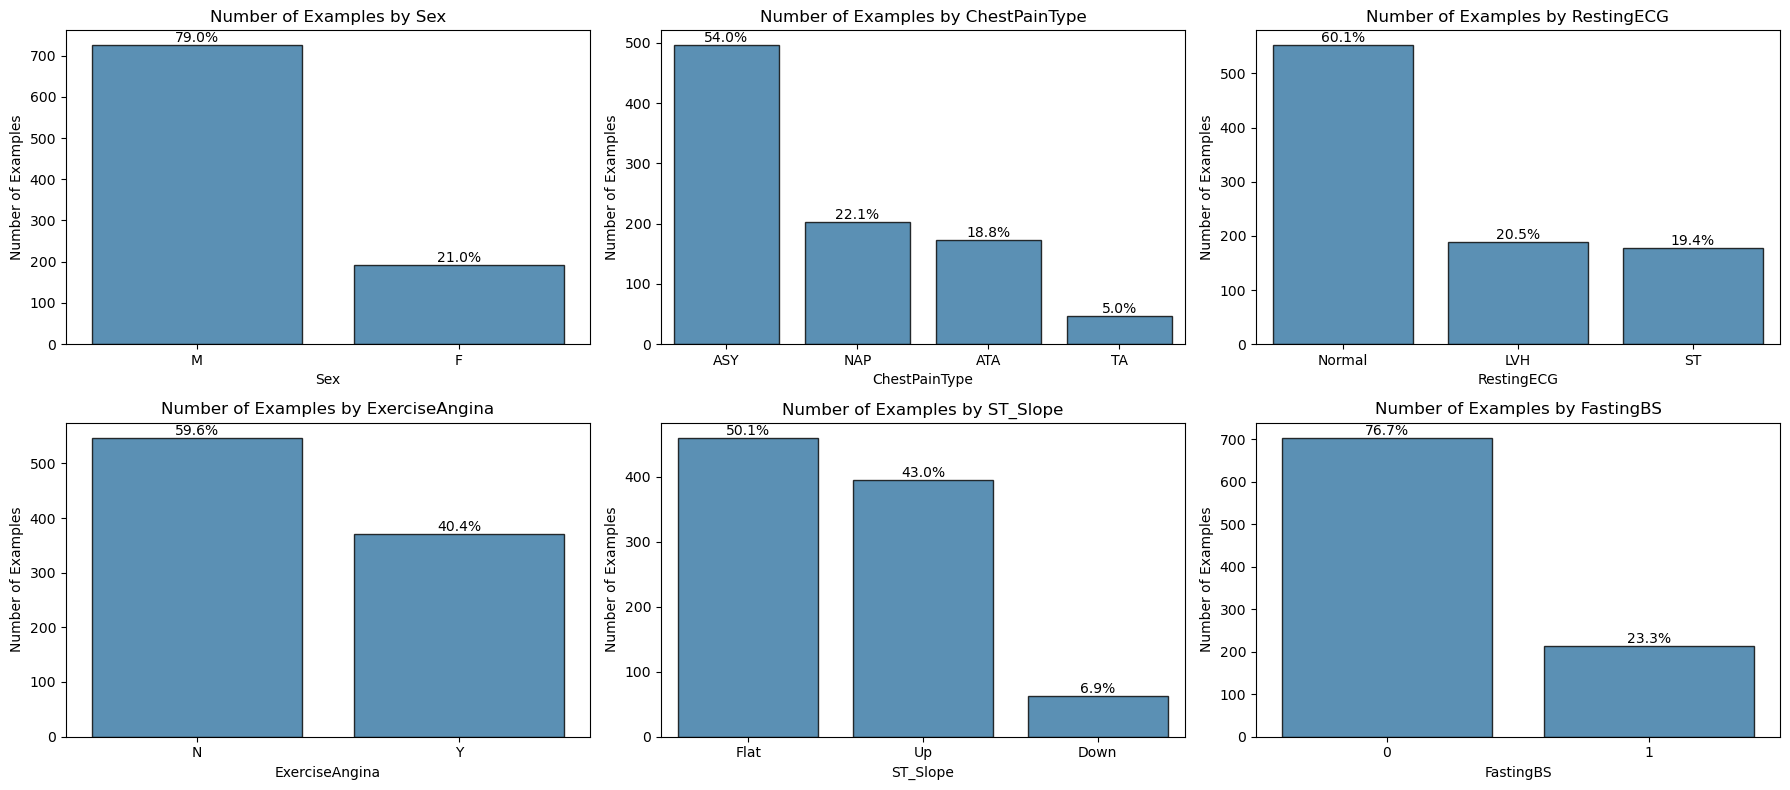

In [188]:
categorical_feature_names = categorical_features.columns.to_list() + ["FastingBS"]

num_features = len(categorical_feature_names)
num_rows = 2
num_cols = math.ceil(num_features / num_rows)


fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows))

for i, cat_feature in enumerate(categorical_feature_names):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    # Calculate number of examples and percentages for each category
    category_counts = df[cat_feature].value_counts()
    category_percentages = category_counts / len(df) * 100

    ax = axes[row, col]

    # Create bar plot for number of examples
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, edgecolor="black", alpha=0.8)

    ax.set_xlabel(cat_feature)
    ax.set_ylabel("Number of Examples")
    ax.set_title(f"Number of Examples by {cat_feature}")

    # Add percentage annotations
    for j, count in enumerate(category_counts):
        percentage = category_percentages[j]
        ax.text(j, count, f'{percentage:.1f}%', ha='center', va='bottom')

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.savefig(os.path.join("visualizations", "categorical_var_examples.png"), dpi=300)
plt.show()

### How does each categorical variable change in conjunction with the target variable?

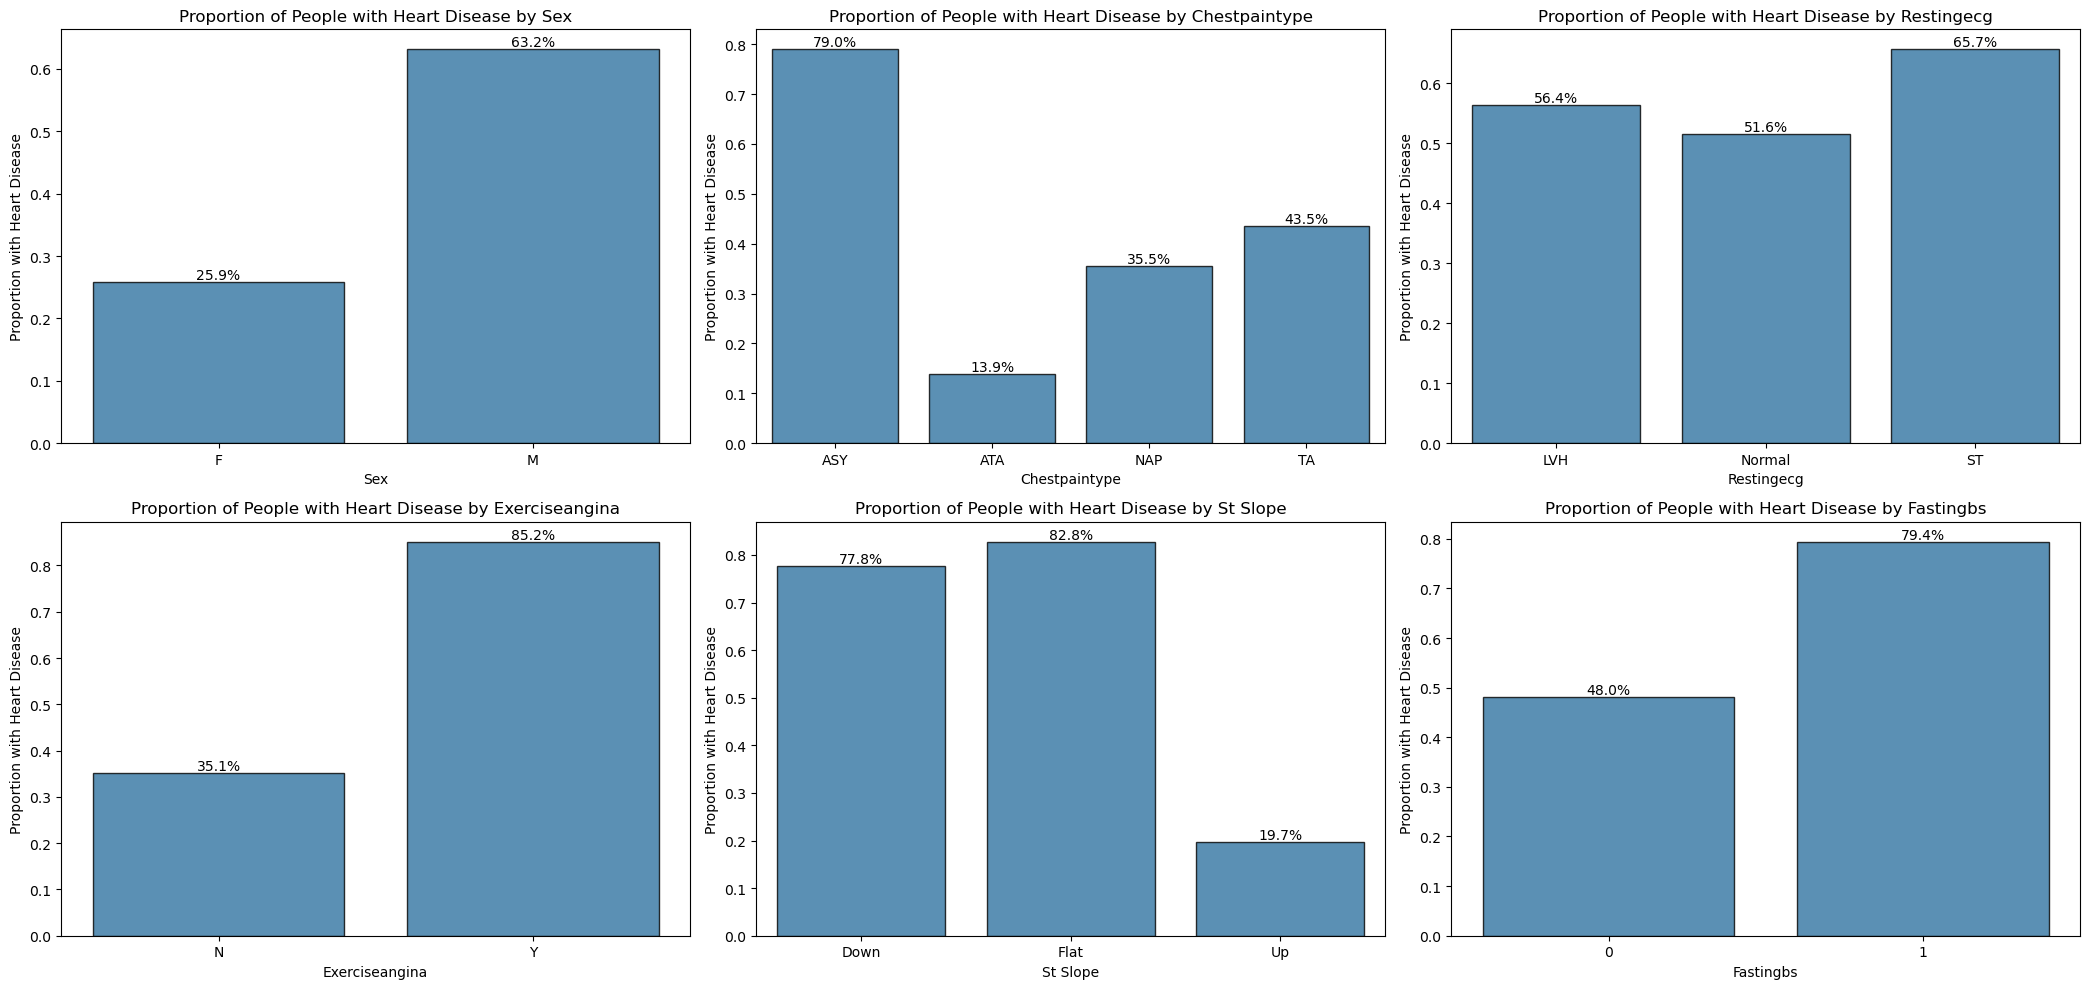

In [326]:
num_features = len(categorical_feature_names)
num_rows = 2
num_cols = math.ceil(num_features / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(7 * num_cols, 5 * num_rows))

for i, cat_feature in enumerate(categorical_feature_names):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax = axes[row, col]

    # Calculate probabilities of heart failure for each category
    category_probabilities = df.groupby(cat_feature)["HeartDisease"].mean()

    # Create bar plot
    bar_plot = sns.barplot(x=category_probabilities.index, y=category_probabilities.values, ax=ax, edgecolor="black", alpha=0.8)

    label = cat_feature.replace("_", " ").title()
    ax.set_xlabel(label)
    ax.set_ylabel("Proportion with Heart Disease")
    ax.set_title(f"Proportion of People with Heart Disease by {label}")

    total = category_probabilities.sum()
    for j, p in enumerate(bar_plot.patches):
        percentage = category_probabilities.values[j] * 100
        ax.text(p.get_x() + p.get_width() / 2, p.get_height(), f"{percentage:.1f}%", ha="center", va="bottom")

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.savefig(os.path.join("visualizations", "categorical_target.png"), dpi=300)
plt.show()

# Feature engineering and scaling

In [328]:
preprocessed_df = df.copy(deep=True)  # make a copy of the original data which we will modify

# Initialize the scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()  # not clear this was required for 'Age', 'RestingBP', or, 'MaxHR' because those were already looking pretty close to Gaussian. Further normalization here is unlikely to hurt, however. A further investigation into normality with QQ-plots and the shapiro wilk test could be a future direction and dictate whether those features get StandardScaler applied to them

# Apply both scalers to each continuous variable
for feature in continuous_feature_names:
    # Perform MinMax scaling
    min_max_scaled_data = min_max_scaler.fit_transform(preprocessed_df[[feature]])

    # Perform Standard scaling on the MinMax scaled data
    min_max_standard_scaled_data = standard_scaler.fit_transform(min_max_scaled_data)

    # Update the original DataFrame with the scaled data
    preprocessed_df[feature] = min_max_standard_scaled_data.flatten()

preprocessed_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,M,ATA,0.410909,0.825070,0,Normal,1.382928,N,-0.832432,Up,0
1,-0.478484,F,NAP,1.491752,-0.171961,0,Normal,0.754157,N,0.105664,Flat,1
2,-1.751359,M,ATA,-0.129513,0.770188,0,ST,-1.525138,N,-0.832432,Up,0
3,-0.584556,F,ASY,0.302825,0.139040,0,Normal,-1.132156,Y,0.574711,Flat,1
4,0.051881,M,NAP,0.951331,-0.034755,0,Normal,-0.581981,N,-0.832432,Up,0


In [193]:
# one hot encoding of categorical variables
preprocessed_df = pd.get_dummies(preprocessed_df, columns=categorical_feature_names, dtype=int)
preprocessed_df.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,FastingBS_0,FastingBS_1
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,0,0,1,0,1,...,0,1,0,1,0,0,0,1,1,0
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,1,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,0,0,1,0,1,...,0,0,1,1,0,0,0,1,1,0
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,1,1,0,1,0,...,0,1,0,0,1,0,1,0,1,0
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,0,0,1,0,0,...,0,1,0,1,0,0,0,1,1,0


# Feature Importance Analysis Using Inferential Statistics

### ANOVA on continuous variables to determine importance

/var/folders/03/g1kt45_d2t9_n8s_b6srk9_w0000gn/T/ipykernel_10833/1709605402.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=anova_scores.index, y=anova_scores["ANOVA F-value"], palette="viridis", ax=ax, edgecolor="black", alpha=0.8)


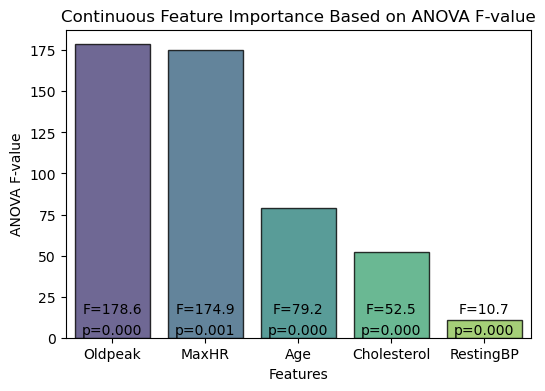

,ANOVA F-value,p-value,significant
Oldpeak,178.615120,3.007953e-18,True
MaxHR,174.913585,1.095315e-03,True
Age,79.160779,9.308309e-13,True
Cholesterol,52.459725,1.137786e-36,True
RestingBP,10.727228,2.390772e-37,True


In [330]:
# The SelectKBest class with f_classif function applies the ANOVA F-value statistical test
# for Feature Selection. It computes the F-value between label/feature for regression tasks.
# Here we choose 'k=all' to keep all features. I could also try to only keep the top k features.
selector = SelectKBest(score_func=f_classif, k="all")

# Perform feature selection. This computes the ANOVA F-value between each feature and the target variable.
fit = selector.fit(preprocessed_df[continuous_feature_names], preprocessed_df["HeartDisease"])

# Create a DataFrame to hold the ANOVA F-value for each feature.
# The F-value is a measure of the difference in variance between the distributions of the feature values
# conditioned on the target classes, relative to the combined variance.
anova_scores = pd.DataFrame(data=fit.scores_, index=continuous_feature_names, columns=["ANOVA F-value"])

# Sort the DataFrame by ANOVA F-value in descending order.
anova_scores = anova_scores.sort_values(by="ANOVA F-value", ascending=False)


anova_scores["p-value"] = fit.pvalues_  # calculate p-values
anova_scores["significant"] = anova_scores["p-value"] < 0.05  # add column to check for significance (p < 0.05)

# Create a bar plot of F-values, and annotate each bar with its p-value
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
barplot = sns.barplot(x=anova_scores.index, y=anova_scores["ANOVA F-value"], palette="viridis", ax=ax, edgecolor="black", alpha=0.8)
ax.set_title("Continuous Feature Importance Based on ANOVA F-value")
ax.set_xlabel("Features")
ax.set_ylabel('ANOVA F-value')

# Annotate each bar with its F-score and p-value
for i, (p_value, f_value) in enumerate(zip(anova_scores['p-value'], anova_scores["ANOVA F-value"])):
    barplot.text(i, 15, f'F={f_value:.1f}', color='black', ha='center')
    barplot.text(i, 2, f'p={p_value:.3f}', color='black', ha='center')

plt.savefig(os.path.join("visualizations", "ANOVA_results.png"), dpi=300)
plt.show()

# Display the DataFrame sorted by F-value
anova_scores = anova_scores.sort_values(by="ANOVA F-value", ascending=False)
anova_scores

ANOVA Takeaways:
1. All continuous variables have a significant effect on target variable
2. RestingBP has a relatively small F score (so more of the variance is unexplained)

### Chi-Squared test on categorical variables to determine feature importance

<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:31: SyntaxWarning: invalid escape sequence '\c'
/var/folders/03/g1kt45_d2t9_n8s_b6srk9_w0000gn/T/ipykernel_10833/59273041.py:31: SyntaxWarning: invalid escape sequence '\c'
  chi2_str = f'$\chi^2$={chi2_score:.1f}'  # Chi-squared symbol with exponent using LaTeX
/var/folders/03/g1kt45_d2t9_n8s_b6srk9_w0000gn/T/ipykernel_10833/59273041.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=chisquare_scores.index, y=chisquare_scores["Chi-Squared Score"], palette="viridis", ax=ax, edgecolor="black", alpha=0.8)


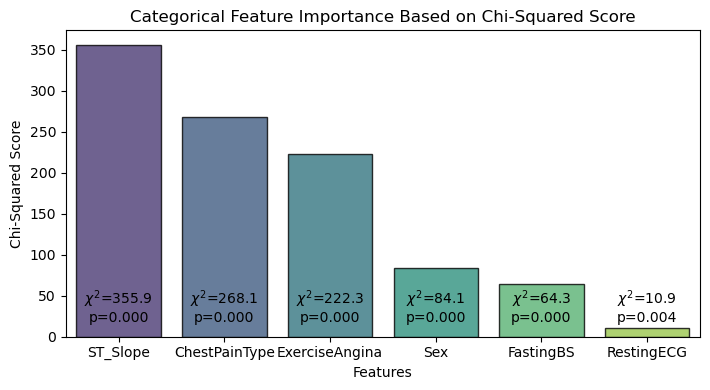

,Chi-Squared Score,p-value,Degrees of Freedom,significant
ST_Slope,355.918443,0.0,2,True
ChestPainType,268.067239,0.0,3,True
ExerciseAngina,222.259383,0.0,1,True
Sex,84.145101,0.0,1,True
FastingBS,64.320679,0.0,1,True
RestingECG,10.931469,0.004229,2,True


In [199]:
# Initialize a DataFrame to store the results
chisquare_scores = pd.DataFrame(index=categorical_feature_names, columns=["Chi-Squared Score", "p-value", "Degrees of Freedom"])

# Loop over each categorical feature
for feature in categorical_feature_names:
    # Create a contingency table
    contingency_table = pd.crosstab(df[feature], df["HeartDisease"])

    # Perform the Chi-squared test
    chi2, p, dof, _ = stats.chi2_contingency(contingency_table)

    # Save the results in the DataFrame
    chisquare_scores.loc[feature, "Chi-Squared Score"] = chi2
    chisquare_scores.loc[feature, "p-value"] = p
    chisquare_scores.loc[feature, "Degrees of Freedom"] = dof

# Add a "significant" column which is True when the p-value is less than 0.05 (indicating significance)
chisquare_scores["significant"] = chisquare_scores["p-value"] < 0.05

# Sort the DataFrame by chi-squared score in descending order.
chisquare_scores = chisquare_scores.sort_values(by="Chi-Squared Score", ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(7.2, 4))
barplot = sns.barplot(x=chisquare_scores.index, y=chisquare_scores["Chi-Squared Score"], palette="viridis", ax=ax, edgecolor="black", alpha=0.8)
ax.set_title("Categorical Feature Importance Based on Chi-Squared Score")
ax.set_xlabel("Features")
ax.set_ylabel("Chi-Squared Score")

# Annotate each bar with its Chi-Squared score and p-value
for i, (p_value, chi2_score) in enumerate(zip(chisquare_scores["p-value"], chisquare_scores["Chi-Squared Score"])):
    chi2_str = f'$\chi^2$={chi2_score:.1f}'  # Chi-squared symbol with exponent using LaTeX
    barplot.text(i, 40, chi2_str, color="black", ha="center")
    barplot.text(i, 18, f"p={p_value:.3f}", color="black", ha="center")

plt.tight_layout()
plt.savefig(os.path.join("visualizations", "chi_sq_results.png"), dpi=300)
plt.show()

chisquare_scores

Chi-Squared test takeaways:
1. All categorical variables have a significant effect
2. Resting ECG has a p-value not much below 0.05, so if I were to remove any feature, it would be the best one to remove, even though it is statistically significant

# Modelling and Predicting

In [332]:
x_train, x_test, y_train, y_test = train_test_split(preprocessed_df.drop("HeartDisease", axis=1), preprocessed_df["HeartDisease"], test_size=0.2, random_state=1)

In [334]:
def calculate_results(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred)
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

    # Calculate model specificity
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    model_specificity = tn / (tn + fp)


    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1,
                     "specificity": model_specificity}
    return model_results

def make_confusion_matrix(y_true, y_pred, classes=("Negative", "Positive"), figsize=(6, 6), text_size=15, save=False, title="Confusion Matrix", include_percent=False, cm=None) -> np.ndarray[(2, 2), int]:
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).
        include_percent (bool): whether to include percentages on the squares
        cm (np.ndarray): a pre-computed confusion matrix which should just be displayed by the function

    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
    plt.style.use("default")
    # Create the confusion matrix (if it doesn't exist yet)
    if cm is None:
        cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # If there are labels for the classes, add them
    if classes is not None:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title=title,
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will be labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if include_percent:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    if save:
        plt.savefig(os.path.join("visualizations", f"{title}.png"), dpi=300, bbox_inches="tight")
        if title == "Confusion Matrix":
            print("Warning! default title on saved confusion matrix")
    plt.show()
    return cm

Initialize dataframe to easily keep track of experiments in an organized way

In [336]:
models_df = pd.DataFrame({"experiment_name": [], "predictions": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "specificity": [], "confusion_matrix": []})
models_df["predictions"] = models_df["predictions"].astype(object)  # this line is needed to enable numpy arrays to enter the "predictions" column
models_df["confusion_matrix"] = models_df["confusion_matrix"].astype(object)  # this line is needed to enable numpy arrays to enter the "predictions" column

In [206]:
def add_experiment(models, experiment_name, predictions, testing_y=y_test, cm=None) -> pd.DataFrame:
    """
    Add a new experiment to the models_df DataFrame.

    Args:
        models (pd.Dataframe): DataFrame to store the models' results.
        experiment_name (str): Name of the experiment.
        predictions (np.ndarray): The model's predicted labels as a numpy array.
        testing_y (np.ndarray): y_test for the model being evaluated
        cm (np.ndarray): flattened confusion matrix for the model

    Returns:
        Updated models DataFrame with the new experiment.
    """
    if experiment_name in models["experiment_name"].values:
        # Experiment name already exists in the DataFrame
        print(f"{experiment_name} already exists in the dataframe. Skipping addition.")
        return models

    # Create a new row dictionary with experiment name, predictions, and other results
    new_row = {"experiment_name": experiment_name, "predictions": predictions}
    results = calculate_results(y_true=testing_y, y_pred=predictions)
    new_row.update(results)

    if cm is not None:
        new_row.update({"confusion_matrix": cm})

    # Add the new row to the DataFrame
    models.loc[len(models)] = new_row
    return models


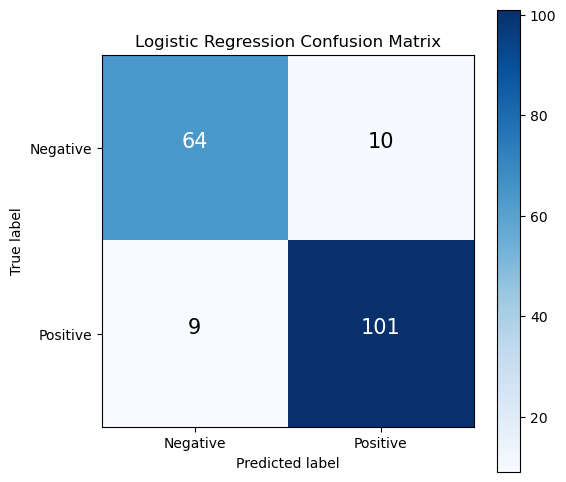

In [207]:
logistic_regressor1 = LogisticRegression(random_state=10)
logistic_regressor1.fit(x_train, y_train)

logistic_regressor1_predictions = logistic_regressor1.predict(x_test)

logistic_regressor1_cm = make_confusion_matrix(y_true=y_test, y_pred=logistic_regressor1_predictions, figsize=(6, 6), title="Logistic Regression Confusion Matrix", save=True, include_percent=False)
models_df = add_experiment(models_df, "logistic_regressor1", logistic_regressor1_predictions, cm=logistic_regressor1_cm)

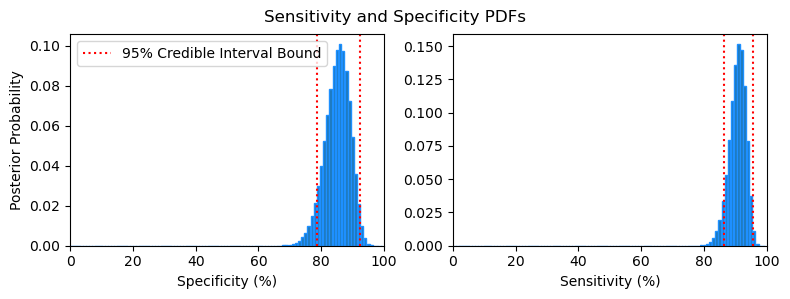

Sensitivity mode = 91.5, 95% CI: (86.5, 95.5)
Sensitivity mode = 86.5, 95% CI: (78.5, 92.5)


In [338]:
from sensitivity_specificity import sensitivity_specificity_pdfs
(specificity_mode, (specificity_min_95, specificity_max_95)), (sensitivity_mode, (sensitivity_min_95, sensitivity_max_95)),  = sensitivity_specificity_pdfs(logistic_regressor1_cm, save=True, hypotheses=100)
print(f"Sensitivity mode = {sensitivity_mode}, 95% CI: ({sensitivity_min_95}, {sensitivity_max_95})")
print(f"Sensitivity mode = {specificity_mode}, 95% CI: ({specificity_min_95}, {specificity_max_95})")

In [340]:
# print(type(dl_model1_preds))
# print(type(y_test))

Hyperparameter optimization for deep learning model

# Trying to improve models by dealing with missing cholesterol values

### Cholesterol Imputation: Replace 0 Cholesterol Values With the Mean

In [356]:
display(df["Cholesterol"].describe())  # unedited cholesterol description
display(df[df["Cholesterol"]!=0]["Cholesterol"].describe())  # cholesterol description excluding 0s

count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

count    746.000000
mean     244.635389
std       59.153524
min       85.000000
25%      207.250000
50%      237.000000
75%      275.000000
max      603.000000
Name: Cholesterol, dtype: float64

In [358]:
mean_imputation_df = df.copy(deep=True)  # make a new dataframe for this
mean_imputation_df["FastingBS"] = mean_imputation_df["FastingBS"].astype(int)

mean_imputation_df.loc[mean_imputation_df["Cholesterol"] == 0, "Cholesterol"] = mean_imputation_df[mean_imputation_df["Cholesterol"] != 0]["Cholesterol"].mean()
  # set it equal to the mean
display(mean_imputation_df["Cholesterol"].describe())

/var/folders/03/g1kt45_d2t9_n8s_b6srk9_w0000gn/T/ipykernel_10833/1285399259.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '244.6353887399464' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mean_imputation_df.loc[mean_imputation_df["Cholesterol"] == 0, "Cholesterol"] = mean_imputation_df[mean_imputation_df["Cholesterol"] != 0]["Cholesterol"].mean()


count    918.000000
mean     244.635389
std       53.318029
min       85.000000
25%      214.000000
50%      244.635389
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

## Attempt 2: replace all 0 cholesterol values with the median, then mode

In [366]:
display(df[df["Cholesterol"]!=0]["Cholesterol"].median())

237.0

In [368]:
median_imputation_df = df.copy(deep=True)  # make a new dataframe for this
median_imputation_df["FastingBS"] = median_imputation_df["FastingBS"].astype(int)

median_imputation_df.loc[median_imputation_df["Cholesterol"] == 0, "Cholesterol"] = median_imputation_df[median_imputation_df["Cholesterol"] != 0]["Cholesterol"].median() # set it equal to the median

display(median_imputation_df["Cholesterol"].describe())

count    918.000000
mean     243.204793
std       53.401297
min       85.000000
25%      214.000000
50%      237.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

In [370]:
models_df = run_models(median_imputation_df.copy(deep=True), continuous_feature_names, categorical_feature_names, models_df, add_experiment, descriptor="median_imputation")

NameError: name 'XGBClassifier' is not defined

In [372]:
mode_imputation_df = df.copy(deep=True)  # make a new dataframe for this
mode_imputation_df["FastingBS"] = mode_imputation_df["FastingBS"].astype(int)

mode_imputation_df.loc[mode_imputation_df["Cholesterol"] == 0, "Cholesterol"] = mode_imputation_df[mode_imputation_df["Cholesterol"] != 0]["Cholesterol"].mode()[0]
  # set it equal to the mean
display(mode_imputation_df["Cholesterol"].describe())

count    918.000000
mean     246.389978
std       53.443234
min       85.000000
25%      214.000000
50%      254.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

In [374]:
print(mode_imputation_df[mode_imputation_df["Cholesterol"] != 0]["Cholesterol"].median())
print(mode_imputation_df[mode_imputation_df["Cholesterol"] != 0]["Cholesterol"].mode()[0])  # need to add the 0 at the end for mode
# median and mode are equal

254.0
254


In [376]:
models_df = run_models(mode_imputation_df.copy(deep=True), continuous_feature_names, categorical_feature_names, models_df, add_experiment, descriptor="mode_imputation")

NameError: name 'XGBClassifier' is not defined

In [378]:
display(models_df.drop(["predictions", "confusion_matrix"], axis=1).sort_index(ascending=False).head(6))

,experiment_name,accuracy,precision,recall,f1,specificity


In [380]:
delete_null_df = df.copy(deep=True)
delete_null_df = delete_null_df[delete_null_df["Cholesterol"]!=0]

delete_null_df["FastingBS"] = delete_null_df["FastingBS"].astype(int)

# display(delete_null_df["Cholesterol"])
# display(delete_null_df["Cholesterol"].describe())
models_df = run_models(delete_null_df, continuous_feature_names, categorical_feature_names, models_df, add_experiment, descriptor="delete_null")
display(models_df.drop(["predictions", "confusion_matrix"], axis=1).sort_index(ascending=False).head(6))

NameError: name 'XGBClassifier' is not defined

### Finding the best model so far according to each metric:

In [382]:
for metric in models_df.columns.to_list()[2:-1]:
    print(f"Top 3 models by {metric}")
    display(models_df.drop("predictions", axis=1).sort_values(by=metric, ascending=False).head(3))

Top 3 models by accuracy


,experiment_name,accuracy,precision,recall,f1,specificity,confusion_matrix


Top 3 models by precision


,experiment_name,accuracy,precision,recall,f1,specificity,confusion_matrix


Top 3 models by recall


,experiment_name,accuracy,precision,recall,f1,specificity,confusion_matrix


Top 3 models by f1


,experiment_name,accuracy,precision,recall,f1,specificity,confusion_matrix


Top 3 models by specificity


,experiment_name,accuracy,precision,recall,f1,specificity,confusion_matrix


Deep learning model performed well, let's try to improve it with hyperparameter tuning

In [384]:
def optimize_dl_model(df, continuous_feature_names, categorical_feature_names, models_df_, descriptor="New", preprocessed=False):
    """
    Run and evaluate machine learning models on the provided dataset.

    Args:
        df (pd.DataFrame): Input DataFrame containing the dataset.
        continuous_feature_names (list): List of continuous feature names.
        categorical_feature_names (list): List of categorical feature names.
        models_df_ (pd.DataFrame): DataFrame to store the models' results.
        descriptor (int or str, optional): Descriptor to differentiate the models. Defaults to "New".
        preprocessed (bool): Whether the data has been preprocessed. If False, does preprocessing. Defaults to False

    Returns:
        pd.DataFrame: Updated models DataFrame with the results of the experiments.
    """
    tf.random.set_seed(10)
    if not preprocessed:
        min_max_scaler = MinMaxScaler()
        standard_scaler = StandardScaler()

        # Apply both scalers to each continuous variable
        for feature in continuous_feature_names:
            # Perform MinMax scaling
            min_max_scaled_data = min_max_scaler.fit_transform(df[[feature]])

            # Perform Standard scaling on the MinMax scaled data
            min_max_standard_scaled_data = standard_scaler.fit_transform(min_max_scaled_data)

            # Update the original DataFrame with the scaled data
            df[feature] = min_max_standard_scaled_data.flatten()

        # One hot encoding of categorical variables
        df = pd.get_dummies(df, columns=categorical_feature_names, dtype=int, drop_first=True)

    # Splitting the data
    x_train, x_test, y_train, y_test_ = train_test_split(df.drop("HeartDisease", axis=1), df["HeartDisease"], test_size=0.2, random_state=1)
    y_train, y_test_ = y_train.astype(int), y_test_.astype(int)

    # Define the function to create the deep learning model. this needs to be redefined so that len(x_train.columns) is local here
    def create_dl_model(layers=1, neurons=32, activation="relu", optimizer="adam"):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Input(shape=(len(x_train.columns),)))

        # Add the specified number of layers with the specified number of neurons
        for _ in range(layers):
            model.add(tf.keras.layers.Dense(neurons, activation=activation))

        model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                      optimizer=optimizer,
                      metrics=["accuracy"])
        return model


    # Wrap your Keras model with KerasRegressor
    dl_model = KerasRegressor(build_fn=create_dl_model, verbose=0)

    # Define the hyperparameters to search
    param_grid = {
        "layers": [1, 2, 3],  # Different numbers of layers
        "neurons": [32, 64, 128],  # Different numbers of neurons per layer
        "activation": ["relu", "tanh"],  # Different activation functions
        "optimizer": ["adam", "sgd"]  # Different optimizers
    }

    # Perform grid search to optimize hyperparameters
    grid = GridSearchCV(estimator=dl_model, param_grid=param_grid, cv=3)
    grid_result = grid.fit(x_train, y_train)

    # Print the best hyperparameters and the corresponding performance
    best_params = grid_result.best_params_
    print(f"Best Score for dl_model_optimized_{descriptor}: {grid_result.best_score_}")
    print(f"Best Parameters for dl_model_optimized_{descriptor}: {best_params}")

    # creates the best model
    dl_model_in = create_dl_model(layers=best_params["layers"],
                                neurons=best_params["neurons"],
                                activation=best_params["activation"],
                                optimizer=best_params["optimizer"])
    dl_model_in.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test_), verbose=False)
    dl_model_in_preds = np.round(dl_model_in.predict(x_test)).flatten()
    cm = confusion_matrix(y_true=y_test_, y_pred=dl_model_in_preds)
    models_df_ = add_experiment(models_df_, f"dl_model_optimized_{descriptor}", dl_model_in_preds, y_test_, cm=cm)  # adds it to the tracker
    return models_df_

In [386]:
# comment so notebook runs faster
models_df = optimize_dl_model(mode_imputation_df, continuous_feature_names, categorical_feature_names, models_df, descriptor="mode")

NameError: name 'tf' is not defined

In [388]:
# comment so notebook runs faster
models_df = optimize_dl_model(median_imputation_df, continuous_feature_names, categorical_feature_names, models_df, descriptor="median")

NameError: name 'tf' is not defined

In [390]:
# comment so notebook runs faster
models_df = optimize_dl_model(mean_imputation_df, continuous_feature_names, categorical_feature_names, models_df, descriptor="mean")

NameError: name 'tf' is not defined

In [392]:
# show deep learning models
dl_models_display = models_df[models_df['experiment_name'].str.startswith('dl')]
dl_models_display = dl_models_display.drop("predictions", axis=1).sort_values(by="experiment_name", ascending=False)
display(dl_models_display)

AttributeError: Can only use .str accessor with string values!

## Adding deep learning gridsearchcv hyperparameter optimization for datasets with regression imputation

In [ ]:
regression_model_dict = {
    "linear": chol_linear_regression1,
    "lasso": lasso_regression1,
    "svr": svr_regression1,
    "ridge": ridge_regression1,
    "random_forest_reg": random_forest_regression1
}
# comment so notebook runs faster
for model_name in tqdm(regression_model_dict.keys(), ncols=50):  # tqdm is loading bar
    preprocessed_regression = preprocess_regression_dataset(needs_cholesterol.copy(deep=True), full_train_regression, regression_model_dict[model_name])
    models_df = optimize_dl_model(preprocessed_regression,
                                  continuous_feature_names,
                                  categorical_feature_names,
                                  models_df,
                                  descriptor=model_name,
                                  preprocessed=True)

In [423]:
display(models_df.drop(["predictions", "confusion_matrix"], axis=1).sort_index(ascending=False).head(10))

,experiment_name,accuracy,precision,recall,f1,specificity


## Metrics on best models

In [ ]:
def retrieve_cm(model_name: str) -> np.ndarray:
    """
    Simple function to retrieve the confusion matrix from the models_df

    :param model_name: The name of the model as it appears in models_df
    :return: The confusion matrix formatted as a 2x2 numpy array
    """
    cm = models_df[models_df["experiment_name"]==model_name]["confusion_matrix"].values[0]
    return np.reshape(cm, (2, 2))

In [ ]:
random_forest_ridge_cm = retrieve_cm("random_forest_ridge")

In [ ]:
make_confusion_matrix(y_true=None, y_pred=None, figsize=(6, 6), title="Random Forest Classifier Confusion Matrix", save=False, include_percent=False, cm=random_forest_ridge_cm)
specificity_tuple, sensitivity_tuple = sensitivity_specificity_pdfs(random_forest_ridge_cm,
                                                                    save=True,
                                                                    hypotheses=100,
                                                                    title="Random Forest Classifier Sensitivity and Specificity PDFs")
(specificity_mode, (specificity_min_95, specificity_max_95)) = specificity_tuple
(sensitivity_mode, (sensitivity_min_95, sensitivity_max_95)) = sensitivity_tuple
print(f"Sensitivity mode = {sensitivity_mode}, 95% CI: ({sensitivity_min_95}, {sensitivity_max_95})")
print(f"Specificity mode = {specificity_mode}, 95% CI: ({specificity_min_95}, {specificity_max_95})")

In [ ]:
display(models_df[models_df["experiment_name"]=="random_forest_ridge"].drop(["predictions", "confusion_matrix"], axis=1))

In [ ]:
dl_model_mean_imputation_cm = retrieve_cm("dl_model_mean_imputation")

In [ ]:
make_confusion_matrix(y_true=None, y_pred=None, figsize=(6, 6), title="Deep Learning Classifier Confusion Matrix", save=True, include_percent=False, cm=dl_model_mean_imputation_cm)
specificity_tuple, sensitivity_tuple = sensitivity_specificity_pdfs(dl_model_mean_imputation_cm,
                                                                    save=True,
                                                                    hypotheses=100,
                                                                    title="Deep Learning Classifier Sensitivity and Specificity PDFs")
(specificity_mode, (specificity_min_95, specificity_max_95)) = specificity_tuple
(sensitivity_mode, (sensitivity_min_95, sensitivity_max_95)) = sensitivity_tuple
print(f"Sensitivity mode = {sensitivity_mode}, 95% CI: ({sensitivity_min_95}, {sensitivity_max_95})")
print(f"Specificity mode = {specificity_mode}, 95% CI: ({specificity_min_95}, {specificity_max_95})")
# calculate_results(y_true=mean)

In [ ]:
display(models_df[models_df["experiment_name"]=="dl_model_mean_imputation"].drop(["predictions", "confusion_matrix"], axis=1))

# Visualizing where a model goes wrong

In [425]:
# Logistic regression
misclassified_indices = logistic_regressor1_predictions != y_test
misclassified_samples = x_test[misclassified_indices]
misclassified_true_labels = y_test[misclassified_indices]
misclassified_predicted_labels = logistic_regressor1_predictions[misclassified_indices]

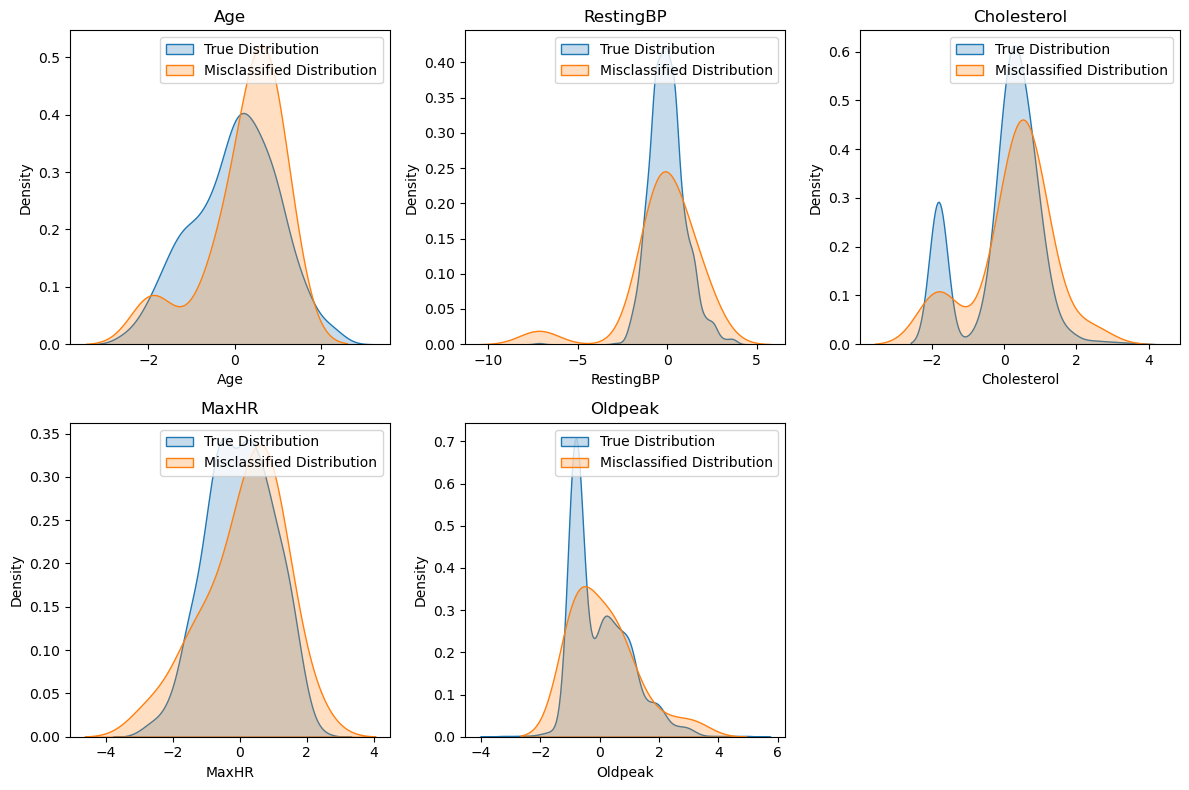

In [427]:
num_features = len(continuous_feature_names)
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

# Flatten the axes array to iterate over it
axes = axes.flatten()

# Loop through each feature and plot the distributions
for i, feature in enumerate(continuous_feature_names):
    if i < num_features:
        ax = axes[i]

        ax.set_title(f"{feature}")
        sns.kdeplot(preprocessed_df[feature], fill=True, label="True Distribution", ax=ax)
        sns.kdeplot(misclassified_samples[feature], fill=True, label="Misclassified Distribution", ax=ax)
        ax.legend()

# Remove the empty subplot
if num_features < num_rows * num_cols:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


# Exporting models

In [429]:
pd.set_option('display.max_rows', None)
display(models_df.drop("predictions", axis=1).sort_index(ascending=False))

,experiment_name,accuracy,precision,recall,f1,specificity,confusion_matrix


### save models_df

In [434]:
models_df.drop("predictions", axis=1).to_csv(os.path.join("data", "model_metrics.csv"), index=False)